In [1]:
#imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats #filters
import scipy.fftpack #fft
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences

np.random.seed(1)

In [39]:
#find files
#function to define path
folder = "data_text_files/"
rats = os.listdir(folder)
rats = list(filter(lambda x: x!=".DS_Store", rats))
print(rats)





#functions

def findfiles(rat, freq):
    path = folder + rat + "/"
    file = path + str(freq) +'.txt'
    return(file)

def skiplines(row_text, file_x):
    line = 0
    fh = open(file_x, "r")
    while True:
        if fh.readline().startswith(row_text):
            break
        line += 1
    return(line)

#filter function

#signal processing 
fs = 1/ .000025 #micro seconds
N = 1024 
T = 1.0 / fs 
nyquist = fs/2
x = np.linspace(0.0, N//fs, N)
xf = np.linspace(0.0, nyquist , N//2)


##################################
#  set high and low pass values  #
##################################
high = 100/nyquist
low = 1500/nyquist

def bandfilter(raw, h, l):
    b, a = scipy.signal.butter(3, [h, l], 'band')
    filt = scipy.signal.filtfilt(b, a, raw)
    return(filt)



#load files into pandas data frame
df_all = pd.DataFrame([])

freqs = [0, 2000, 4000, 8000, 16000, 24000, 32000]
# dbs = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15] --> read from file some stops at 20, 15 or 10

f = 0

for rat in rats:
    i = 0
    #find file
    for i in range(7):
        file = findfiles(rat, i)
        # print(file)

        #check line index for intensity
        line = skiplines("Intensity", file)

        #open file
        dbs = (pd.io.parsers.read_csv(file, skiprows = line-1, header=None))[1:2].dropna(axis = 1)
        dbs = np.array(dbs)[:,1:].astype('int')

        # find abr data
        line = skiplines('Data', file)
        data = pd.io.parsers.read_csv(file, skiprows=line)
    
        #Keeping only the column containing the average 
        data = data[[c for c in data.columns if c.startswith('Average(uV):')]]
        data.columns = np.arange(len(data.columns))



        



        

    #load entries        
        d = 0
        
        for d in range(0, (dbs.size-1)):    
            # range starts at 1 to skip the first 90?    
            d = d+1
            #determine switch to right ear
            if dbs[:,d] == 90:
                index = d
                

            #reset counter to align with data
            d = d-1
            db = dbs[:, d]
            filt = bandfilter(data.loc[:,d], high, low)

            # left data entry
            if index > d:
                new_entry = pd.Series({'ratname':rat,'frequency':freqs[i],'dB':db,'L/R': 'L' ,'ABR':data.loc[:,d].to_numpy(), 'filtered':filt})
                df_all = pd.concat([df_all, new_entry], ignore_index=True, axis = 1)

            # right data entry
            if d >= index:
                new_entry = pd.Series({'ratname':rat,'frequency':freqs[i],'dB':db,'L/R':'R','ABR': data.loc[:,d].to_numpy(), 'filtered':filt})
                df_all = pd.concat([df_all, new_entry], ignore_index=True, axis = 1)


df_all = df_all.transpose()

['R165183_042022', 'R144883_091321', 'R165184_042222', 'R144884_091321', 'R165182_042022', 'R165181_041322', 'R165176_04102022', 'R144863_090921', 'R165185_042222']


In [16]:
df_all

# df_all.loc['ratname']

,ratname,frequency,dB,L/R,ABR,filtered
0,R165183_042022,0,[90],L,"[0.6222, 0.6465, 0.6341, 0.603, 0.5997, 0.5903...","[0.1282853919119677, 0.12799841100887854, 0.12..."
1,R165183_042022,0,[85],L,"[0.3377, 0.3735, 0.3994, 0.3959, 0.4298, 0.420...","[0.19058344322883228, 0.18342033957333737, 0.1..."
2,R165183_042022,0,[80],L,"[0.1242, 0.1517, 0.1507, 0.1729, 0.1748, 0.186...","[0.03977011373360641, 0.05012652068542527, 0.0..."
3,R165183_042022,0,[75],L,"[-1.3207, -1.3194, -1.3475, -1.3405, -1.3589, ...","[0.030327211932464092, 0.01251895035128832, -0..."
4,R165183_042022,0,[70],L,"[-1.0985, -1.1145, -1.1232, -1.1513, -1.1701, ...","[-0.13294269679396067, -0.1677016023754505, -0..."
...,...,...,...,...,...,...
1938,R165185_042222,32000,[40],R,"[0.1493, 0.1467, 0.1417, 0.1369, 0.1307, 0.128...","[0.018075575597540715, 0.016136517777631084, 0..."
1939,R165185_042222,32000,[35],R,"[-0.2765, -0.2612, -0.2474, -0.2326, -0.2182, ...","[-0.01694826997327973, -0.00583640974632446, 0..."
1940,R165185_042222,32000,[30],R,"[0.0382, 0.0133, -0.0089, -0.0305, -0.0486, -0...","[-0.044815107786200445, -0.06245533414350709, ..."
1941,R165185_042222,32000,[25],R,"[-0.0922, -0.0999, -0.1117, -0.1228, -0.1316, ...","[-0.032800701055585704, -0.040682862695051863,..."


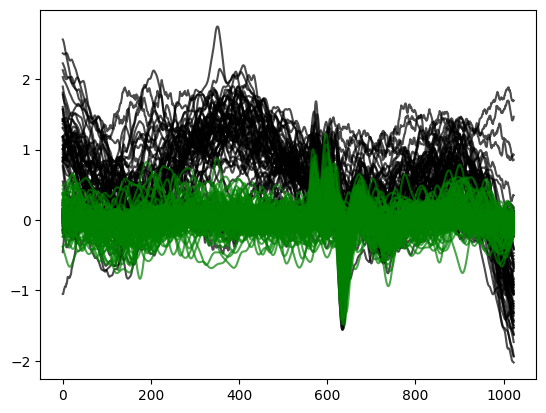

In [18]:
#visualize filter

fi = df_all['filtered']
ra = df_all['ABR']



def filt_plot(min, max, c):
    for w in range(min, max):
        plt.plot(fi[w], c,  alpha = .7)

def ra_plot(min, max, c):
    for w in range(min, max):
        plt.plot(ra[w], c, alpha = .7)



ra_plot(100, 214, 'black')
filt_plot(100, 214, 'g')






Text(0.5, 1.0, 'Average filtered ABR per frequency')

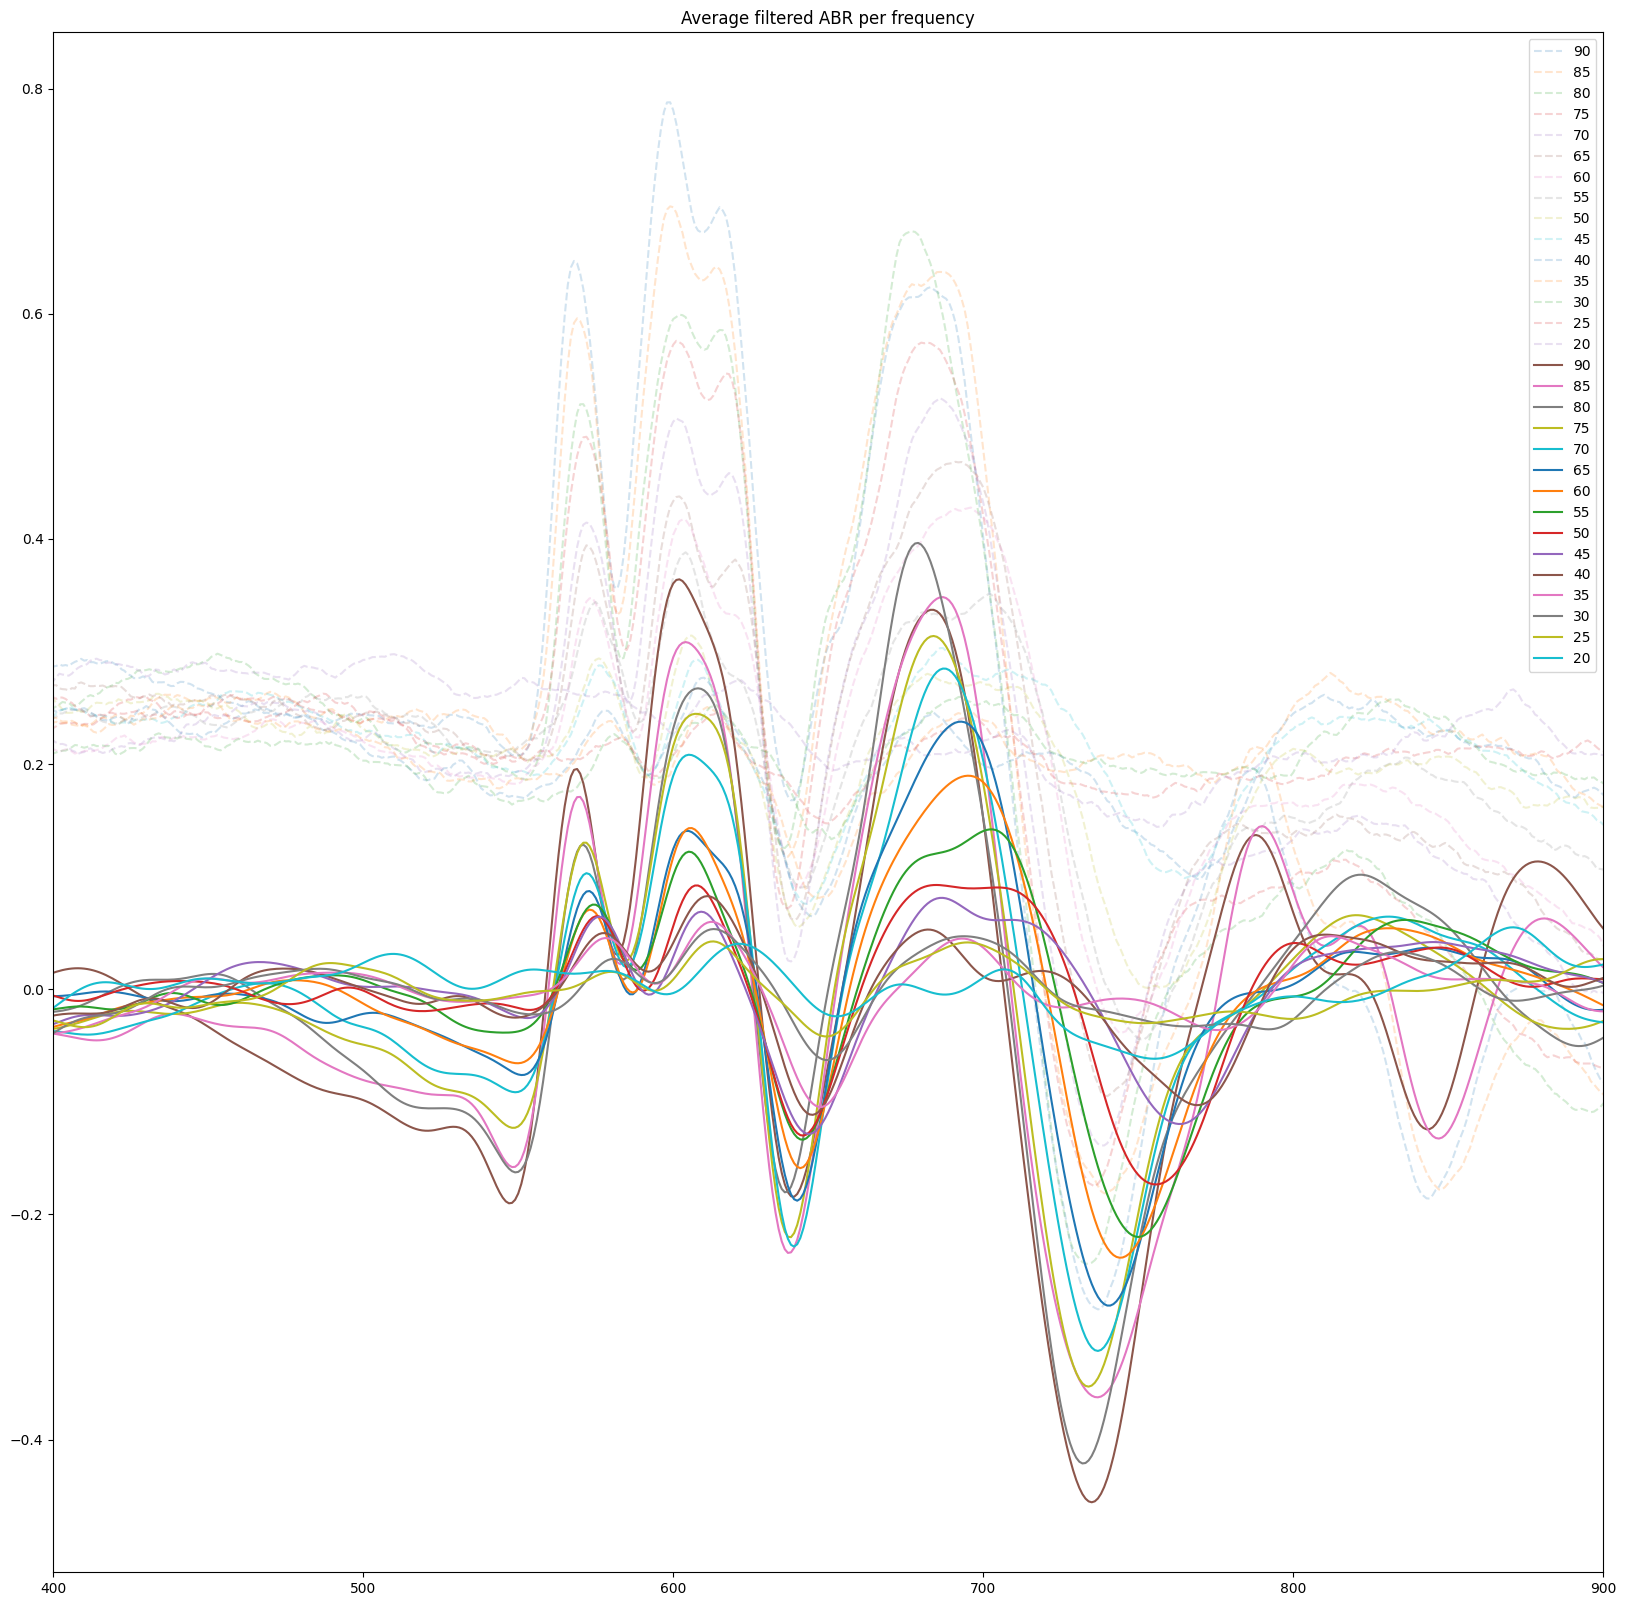

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))




########## AVG raw ABR



#make a function to plot mean of each signal
def ABRplot(db):
    plt.subplot(111)
    signal = [df_all[df_all['dB'] == db]['ABR']]
    mean = np.mean(signal)
    plt.plot(mean, alpha = .2, label = db, linestyle='dashed' )
    plt.xlim(400,900)

###### plot mean ABR signal
for d in counter:
    ABRplot(d)

plt.legend()
plt.title("Average ABR per frequency")





#make a function to plot mean of each signal
def averageplot(db):
    plt.subplot(111)
    signal = [df_all[df_all['dB'] == db]['filtered']]
    mean = np.mean(signal)
    plt.plot(mean, alpha = 1, label = db)
    plt.xlim(400,900)

###### plot mean filtered signal

counter = dbs[0,:15]

for d in counter:
    averageplot(d)

plt.legend()
plt.title("Average filtered ABR per frequency")



# print("length of all data:  ", df_all.size, "   ?")
# print("number of intesities tested [95--> 25]:  ", dbs.size)
# print("Number of samples included in the mean of each intesity:  ", signal.size)

In [38]:
#functio to select by ratname or date

def ratname(ratcode):
    output = df_all[df_all['ratname'].str.contains(ratcode)]
    return(output)
    


ratname('042022')

,ratname,frequency,dB,L/R,ABR,filtered
0,R165183_042022,0,[90],L,"[0.6222, 0.6465, 0.6341, 0.603, 0.5997, 0.5903...","[0.1282853919119677, 0.12799841100887854, 0.12..."
1,R165183_042022,0,[85],L,"[0.3377, 0.3735, 0.3994, 0.3959, 0.4298, 0.420...","[0.19058344322883228, 0.18342033957333737, 0.1..."
2,R165183_042022,0,[80],L,"[0.1242, 0.1517, 0.1507, 0.1729, 0.1748, 0.186...","[0.03977011373360641, 0.05012652068542527, 0.0..."
3,R165183_042022,0,[75],L,"[-1.3207, -1.3194, -1.3475, -1.3405, -1.3589, ...","[0.030327211932464092, 0.01251895035128832, -0..."
4,R165183_042022,0,[70],L,"[-1.0985, -1.1145, -1.1232, -1.1513, -1.1701, ...","[-0.13294269679396067, -0.1677016023754505, -0..."
...,...,...,...,...,...,...
1074,R165182_042022,32000,[40],R,"[-0.0108, -0.0189, -0.0265, -0.0338, -0.0399, ...","[-0.03413676150129848, -0.041987867646276135, ..."
1075,R165182_042022,32000,[35],R,"[0.1528, 0.1563, 0.1576, 0.1559, 0.1502, 0.143...","[0.045318198924515725, 0.044790879118819814, 0..."
1076,R165182_042022,32000,[30],R,"[-0.1014, -0.0956, -0.0853, -0.0748, -0.0671, ...","[-0.07380052574335084, -0.07202264094493574, -..."
1077,R165182_042022,32000,[25],R,"[0.0747, 0.0795, 0.0806, 0.077, 0.0679, 0.0534...","[-0.018239861067382453, -0.028209302205322525,..."


ratname                                         R144883_091321
frequency                                                    0
dB                                                        [50]
L/R                                                          L
ABR          [-0.0571, -0.0413, -0.0088, -0.0429, -0.0619, ...
filtered     [-0.012939277939539124, -0.014525077069340243,...
Name: 224, dtype: object
RMS:  0.1083447581098894
RMS of nf:  0.061080493133408555


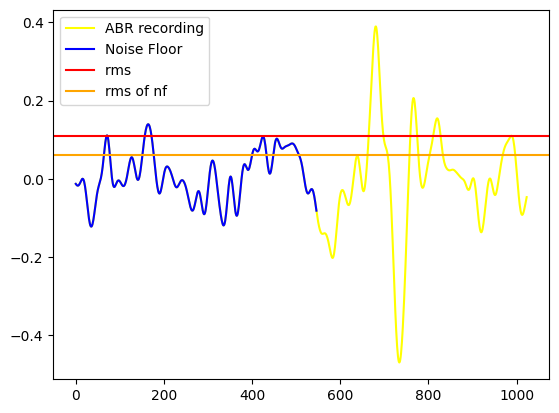

In [131]:
#calculate noise floor

####### testing random samples of data #########
x = 224
################################################


#*********** note sero position   ***********
z_pos = 548 -1



print(df_all.loc[x])
plt.plot(df_all['filtered'][x], color = 'yellow', label = 'ABR recording')

data = df_all['filtered'][x]
nf = data[:z_pos]
rms = np.sqrt(np.mean(data**2))
rms_nf = np.sqrt(np.mean(nf**2))

print("RMS: ", rms)
print("RMS of nf: ", rms_nf)


plt.plot(nf, color = 'blue', label = 'Noise Floor')
plt.axhline(y = rms,color = 'r', label = 'rms ')
plt.axhline(y = rms_nf ,color = 'orange', label = 'rms of nf')

plt.legend()
plt.show()









In [ ]:
#determine threshold

# ONLY signal is present data as input for find peaks 


In [ ]:
#find peaks

#select peaks of interest

In [ ]:
#peak prominencces to detect node to peak (amplitude)
#find node latency